In [1]:
import nltk
import scipy
import pickle
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import utils
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV

np.random.seed(42)

In [2]:
import json
from bs4 import BeautifulSoup
import re


def clean_text(raw_text: str) -> str:
    if raw_text is None:
        return ''

    soup = BeautifulSoup(raw_text, features="html.parser")
    raw_text = soup.get_text()
    raw_text = raw_text.replace('\n', ' ').replace('\xa0', ' ')
    return raw_text


def read_json_as_df(path: str) -> pd.DataFrame:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append([clean_text(data['post'].get('body', None)),
                              data['priority']])

    df = pd.DataFrame(data=json_data, columns=('text', 'priority'))

    return df

def read_json_text(path: str, tag: str) -> list:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append(clean_text(data.get(tag, None)))

    return json_data

In [3]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [4]:
sentences = read_json_text('../Data/message.json', 'body')

c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "D:" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "............." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "..." looks like a filename, not mark

In [5]:
train_df = read_json_as_df('../Data/combined-train.json')
test_df = read_json_as_df('../Data/combined-test.json')

In [6]:
# train_df.text = train_df.text.str.strip()
train_df = train_df[train_df.text != '']

# test_df.text = test_df.text.str.strip()
test_df = test_df[test_df.text != '']

In [7]:
#-----------------------------------------------------------------
def tokenize(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    vectors = [(model.infer_vector(doc.words, steps=30)) for doc in sents]
    return vectors

#-----------------------------------------------------------------

In [8]:
full_train = [TaggedDocument(words=tokenize(sent), tags=[i]) for i,sent in tqdm(enumerate(sentences))]

321673it [03:09, 1696.48it/s]


In [9]:
train_tagged = train_df.apply(
    lambda r: TaggedDocument(words=tokenize(r.text), 
                             tags=[r.priority]), axis=1)
test_tagged = test_df.apply(
    lambda r: TaggedDocument(words=tokenize(r.text), 
                             tags=[r.priority]), axis=1)

In [10]:
%%time

model = Doc2Vec(documents=full_train, 
                dm=0, 
                workers=10, 
                min_count=5,
                epochs=30,
                vector_size=64,
                window=12
               )

Wall time: 8min 9s


In [18]:
# model.save('./doc2vec_svm_model/combined_d2v_model')

In [12]:
# model = Doc2Vec.load('./doc2vec_svm_model/combined_d2v_model')

In [13]:
ytrain, xtrain = train_df.priority, vec_for_learning(model, train_tagged)
ytest, xtest = test_df.priority, vec_for_learning(model, test_tagged) 

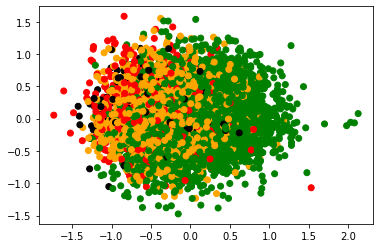

In [14]:
pca = PCA(n_components=2).fit(xtrain)

features_2d = pca.transform(xtrain)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

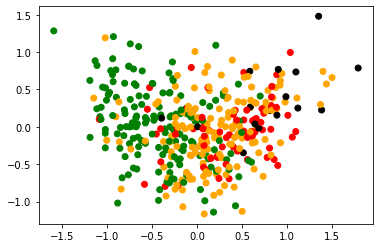

In [15]:
pca = PCA(n_components=2).fit(xtest)

features_2d = pca.transform(xtest)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [21]:
%%time

params = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100)

# params = [
#     {'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'class_weight':['balanced']},
# ]

# clf = GridSearchCV(estimator=SVC(),
#                          param_grid=params,
#                          n_jobs=10,
#                          scoring='f1_macro',
#                          cv=5)

svc_searched_clf = clf.fit(xtrain, ytrain)


print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

Wall time: 4.57 s


In [23]:
# pickle.dump(clf, open('./doc2vec_svm_model/doc2vec_svm_model.sav', 'wb'))

In [55]:
# clf = pickle.load(open('./doc2vec_svm_model/svm_model.sav', 'wb'))

In [22]:
predicted_priority = svc_searched_clf.predict(xtest)    
print_results(ytest, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.68      0.66      0.67       154
    escalate       0.60      0.71      0.65        17
       green       0.75      0.86      0.80       158
         red       0.59      0.42      0.49        69

    accuracy                           0.70       398
   macro avg       0.66      0.66      0.65       398
weighted avg       0.69      0.70      0.69       398


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.6030160815209642

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.90      0.81      0.85       240
       green       0.75      0.86      0.80       158

    accuracy                           0.83       398
   macro avg       0.82      0.84      0.83       398
weighted avg       0.84      0.83      0.83       398


----URGENT - 'red + escalate

In [33]:
test_df['prediction'] = predicted_priority
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 400

In [35]:
test_df[test_df.priority != test_df.prediction]

,text,priority,prediction
4,"Hey @loves netballI have been in the exact same situation as you. Back in 2014 I spoke to a kids helpline counsellor Rory and she was my favourite! We spoke 3 times a week for a year. Then on the 24th of November 2015 she left, my whole word came crashing down. She was my world and my rock I couldn't imagine fighting without her. But do you know what I have and I am. Every day I still think I wonder how she is, if only I could tell her how far I've come. Your never gonna stop missing her/him but all you have to do is just tell yourself you had this person for this long and its time for them to leave think of it as a dollar coaster if you stayed on the same rollercoaster itd get boring so you have to change. Same with counsellors she/ he wouldn't be special if you never left them. I'm always here if u need a hand head up and stay strong everything will be okay",green,escalate
7,"@loves netballthank you (: naturally ive just been scared of anonymity and the fear of calling, but I will give it a try",green,amber
12,"HI @Mistakes It sounds like you have a lot going on. Maybe something that could be tried first is making sens of the emotions that you feel. Is there any way you can seperate them? maybe youre feeling confused, sad, angry... etc. I know this is a bit silly to say, but I am sure your mom is trying her best to understand you. It is hard for someone to know exactly what you are thikning, so maybe with some help, you can explain to her exactly what you are feeling and how she might be able to help you. I know for me, I thought my mum just didnt understand me. She didnt know what i was talking about, and she certainly didnt understand what i was going through. With some help from a counsellor, I was able to sort of understand things through what she might be seeing about me, without me telling her what i felt. WE then worked together so that i could approach her and tell her what she was doing that was making me feel uncomfortable and then we spoke about what i wanted her to be doing for me, as in her responses and the way she spoke to me. OUr relationship now is so much better. YOu sound like you are really stuck at the moment. Have you thought about seeing someone? Maybe KHL, eheadspace for starters?I can recommend both, especially if youre not sure where to start.",green,amber
13,"Hey, @letitgo .Thank you so much for the kind words. I truly appreciate it and I think I'm going to seek some professional help no matter what people say about me.And I'm not Australian. In fact I'm halfway across the world. I live in Tunisia ( Don't know if you heard of it before ) but thank you for your support. I really appreciate it .",amber,green
15,"@Bree-RO I have to wait for the whole lot to cook (meat and vegetable pasties, sounds simple but I've never made them before). I'm being really stubbon and refusing to talk to them until they apologise. What do I do now that no one cares about that stuff that happened years ago? I've been trying to google things but not having any luck. It seems that I really did deserve everything that happened",amber,green
18,"Dear world... Any relationship(s), consists of at least two, no less... Any form of communication would be nice for people who give a damn once in a while. Talking is better for someone else who listens, rather than yourself that doesn't. Friendship is more vauable than love itself, for those who require one for maintaining sanity. Life is too short for opportunities to make a difference. NOTE TO SELF: Forget about talking, it's overated. #Truth Peace... - C.",amber,green
26,Not sure what to say but... Getting really sick of the 'hang in there' comments. And the 'oh I've been depressed too and I survived'. Pretty negative but all I can think is.. Good for you. How long can I keep my head above water for? Losing hope. Wanting some realistic replies xx,red,amber
27,"My boyfriend and I have been together for 3yrs - in that time he has never had constant emplo

In [44]:
test_df.loc[38]

text          Hey guys. I'm offically moving out of home! WooI personally am excited. I thought to make a discussion about moving out experiences.? Aye? aha.Whats your moving out experience?
priority                                                                                                                                                                                 amber
prediction                                                                                                                                                                               green
Name: 38, dtype: object